In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from dython.nominal import associations
from wordcloud import WordCloud
import random
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
random.seed(42)

In [2]:
df= pd.read_csv('spotifyData.csv', encoding='ISO-8859-1')
df = df.drop(['X'], axis=1) #removed column of indexes 
df = df.rename(columns={'bpm':'beats per minute',
                    'top.genre':'genre','nrgy':'energy','dnce':'danceability', 'dB':'loudness dB',
                    'spch':'speechiness','live':'liveness','val':'valence','dur':'duration','acous':'acousticness',
                    'pop':'popularity', 'emo' : 'bad feeling', 'ins': 'instrumentalness'})
df.head()

,title,artist,genre,year,beats per minute,energy,danceability,loudness dB,liveness,valence,duration,acousticness,speechiness,popularity,bad feeling,instrumentalness
0,"Hey, Soul Sister",Train,neo mellow,2010,97.0,89.0,67.0,NaN,8.0,80.0,217.0,19.0,4.0,83.0,16.920,92.16
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82.0,30.456,73.92
2,TiK ToK,Kesha,dance pop,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80.0,24.534,82.56
3,Bad Romance,Lady Gaga,dance pop,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,NaN,24.534,92.16
4,Just the Way You Are,Bruno Mars,pop,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78.0,48.222,92.16


# EDA 

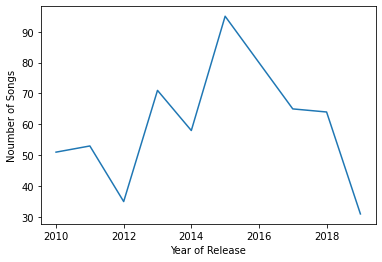

In [3]:
new_df = df[['year','title']].groupby('year').count()

sns.lineplot(x='year',y='title',data=new_df)

plt.ylabel('Noumber of Songs')
plt.xlabel('Year of Release')
plt.show()

Top of 10 genres from 2010 to 2019

In [4]:
def get_top_df(df, top = 11): #change 'top' value to see another top 

    top_lst = df.iloc[:]['genre'].value_counts().index[top:]
    df_other = df.replace(top_lst, 'Other')
    order_lst = list(df_other['genre'].value_counts().index)
    order_lst.remove('Other') #remove first 'Other'
    order_lst.append('Other') #append to the end 'Other'

    return df_other, order_lst

Text(0.5, 10.255999999999986, 'Number of songs')

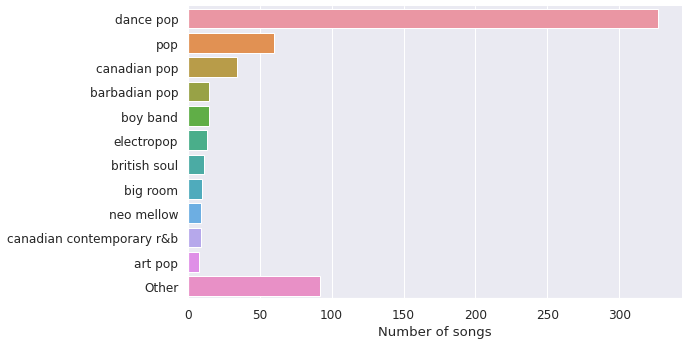

In [5]:
sns.set(font_scale=1.1)

df_top, order_lst = get_top_df(df)

sns.catplot(y = 'genre', data = df_top, kind = 'count', order= order_lst, aspect=2)
plt.ylabel('')
plt.xlabel('Number of songs')



Text(0.5, 10.255999999999986, 'Number of songs')

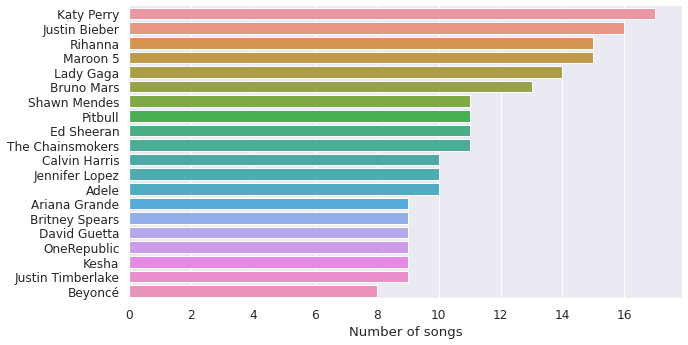

In [6]:
sns.set(font_scale=1.1)

order = df['artist'].value_counts().index[:20]

sns.catplot(y = 'artist', data = df_top, kind = 'count', aspect=2, order = order)
plt.ylabel('')
plt.xlabel('Number of songs')


Percentage normalization

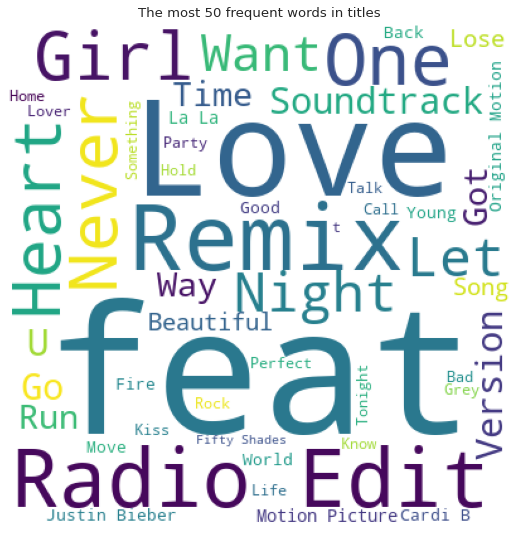

In [7]:
wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', max_words = 50, colormap="viridis",
                min_font_size = 10).generate(" ".join(df['title']))

plt.figure(figsize=(7, 10))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"The most {50} frequent words in titles")
plt.show()

Top of 3 genres from 2010 to 2019

In [8]:
counted_genre = df.groupby(['genre', 'year']).size().unstack(fill_value=0)

In [9]:
df1 = pd.DataFrame()
for i in list(counted_genre.columns):
    df2 = counted_genre[i].sort_values(ascending=False)[:3]
    dict = {'Amount of songs': list(df2.values), 'genre': df2.index, 'year':i}
    tmp = pd.DataFrame(dict)
    df1 = df1.append(tmp, ignore_index=True)

Text(0, 0.5, 'Amount of songs')

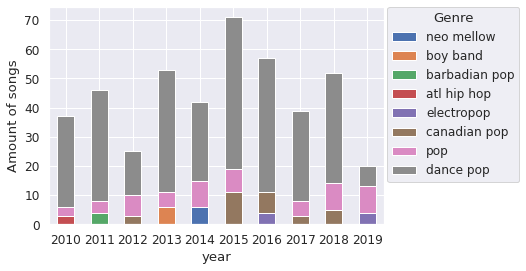

In [10]:
orderOfgenres = df1['genre'].value_counts().index[: : -1]
ax = df1.pivot(index='year', columns='genre', values='Amount of songs').iloc[:][orderOfgenres].plot(kind='bar', stacked=True, rot=0)

plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, title = "Genre")
plt.ylabel('Amount of songs')

In [11]:
df.isnull().sum(axis = 0)


title                0
artist               0
genre                0
year                 0
beats per minute     5
energy               3
danceability         7
loudness dB          6
liveness             6
valence             12
duration             2
acousticness         8
speechiness          4
popularity           7
bad feeling          0
instrumentalness     0
dtype: int64

## Fixing nan values with KNNImputer

In [12]:
import numpy as np
from sklearn.impute import KNNImputer

FROM THE INTERNET
With this imputer, the problem is choosing the right value for k. As it's hard to use GridSearch to tune it, we can take a visual approach for comparison:

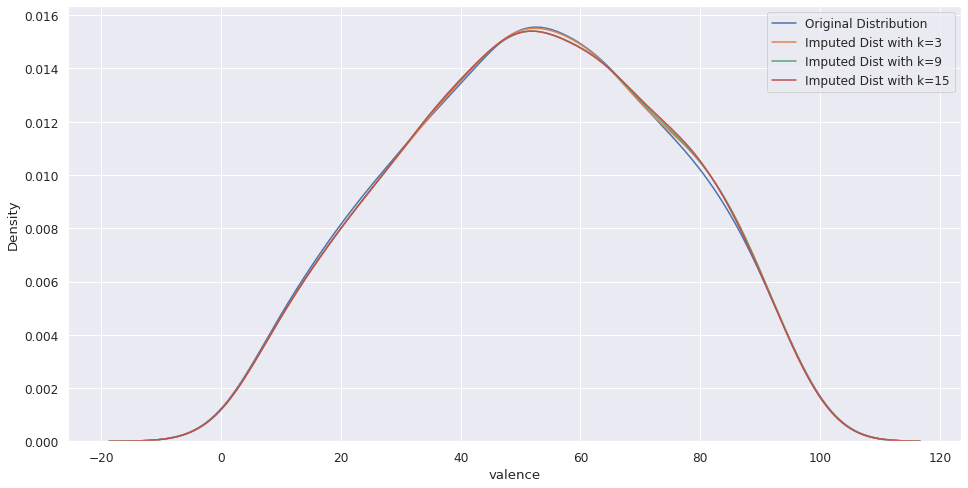

In [13]:
df_tmp = df.copy()
n_neighbors = [3, 9, 15]

fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sns.kdeplot(df['valence'], label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    df_tmp.iloc[:, 4:] = knn_imp.fit_transform(df.iloc[:, 4:])
    sns.kdeplot(df_tmp['valence'], label=f"Imputed Dist with k={k}")

plt.legend()

FROM THE INTERNET
In the above plot, we compare the different KNN imputations for the features using Probability Density plots. The closer the imputed distribution comes to the original, the better was the imputation. Here, it seems k=3 is the best choice.

In [14]:
knn_imp = KNNImputer(n_neighbors=3)
df.iloc[:, 4:] = knn_imp.fit_transform(df.iloc[:, 4:])

## Fixing nan values with median value

In [15]:
for i in range(3, 14): # Nan values are changed to a mean value that depends from genre name #until 'pop' columns 
    df_nan = df[df.iloc[:, i].isna()]
    df_nan = df_nan.loc[:, ['genre']]
    
    for j in range(len(df_nan)):
        artist_genre = df_nan.iloc[j].values
        df_artist_genre = df[df.loc[:, ['genre']].isin(artist_genre).all(axis=1)]
        meadian = df_artist_genre.iloc[:, i].dropna().median() # Why is here not mean? Beacuase I have ourliers in the dataset and also distribution is not simmetrical   
        index = df_artist_genre[df_artist_genre.iloc[:, i].isna()].index
        df.iloc[index, i] = meadian #

In [16]:
df.isnull().any()

title               False
artist              False
genre               False
year                False
beats per minute    False
energy              False
danceability        False
loudness dB         False
liveness            False
valence             False
duration            False
acousticness        False
speechiness         False
popularity          False
bad feeling         False
instrumentalness    False
dtype: bool

In [17]:
df[df['beats per minute'].isnull()]

,title,artist,genre,year,beats per minute,energy,danceability,loudness dB,liveness,valence,duration,acousticness,speechiness,popularity,bad feeling,instrumentalness


In [18]:
df.iloc[273, 4] = 129 # found by the internet

### Correlation Heatmap

Calculate the correlation/strength-of-association of features in data-set with both categorical and continuous features using:

* Pearson's R for continuous-continuous cases
* Correlation Ratio for categorical-continuous cases
* Cramer's V or Theil's U for categorical-categorical cases

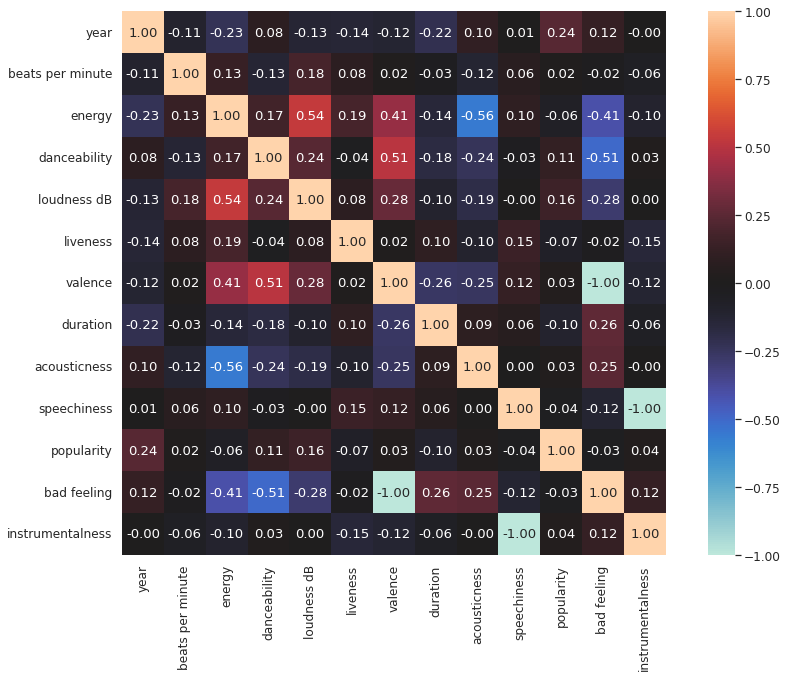

In [19]:
complete_correlation= associations(df.iloc[:, 3:], figsize=(15,10), clustering = False)

/home/aigaf/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='valence', ylabel='danceability'>

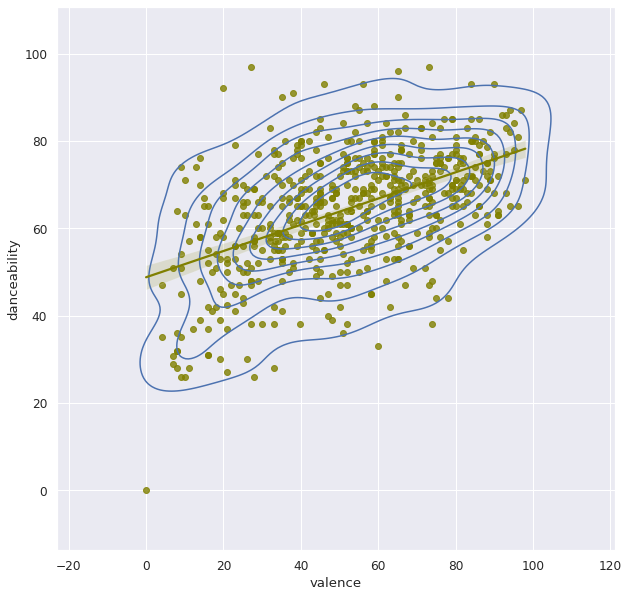

In [20]:
fig = plt.subplots(figsize = (10,10))

sns.regplot(x = 'valence', y = 'danceability', data = df, color = 'olive')

sns.kdeplot(df['valence'], df['danceability'])

If song is at more positive mood than it's more danceable

/home/aigaf/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loudness dB', ylabel='energy'>

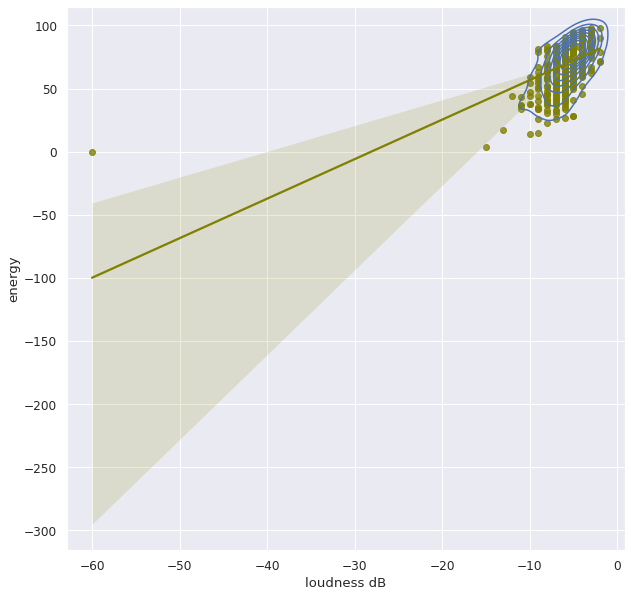

In [21]:
fig = plt.subplots(figsize = (10,10))

sns.regplot(x = 'loudness dB', y = 'energy', data = df, color = 'olive')

sns.kdeplot(df['loudness dB'], df['energy'])

energy and acousticness are negativly correletad, also we found one really weird value with coordinates (0, 0). We should check it

In [22]:
df[df['valence'] == 0]

,title,artist,genre,year,beats per minute,energy,danceability,loudness dB,liveness,valence,duration,acousticness,speechiness,popularity,bad feeling,instrumentalness
442,Million Years Ago,Adele,british soul,2016,0.0,0.0,0.0,-60.0,0.0,0.0,227.0,0.0,0.0,0.0,84.6,96.0


In [23]:
df = df.drop(df[df['energy'] == 0].index)

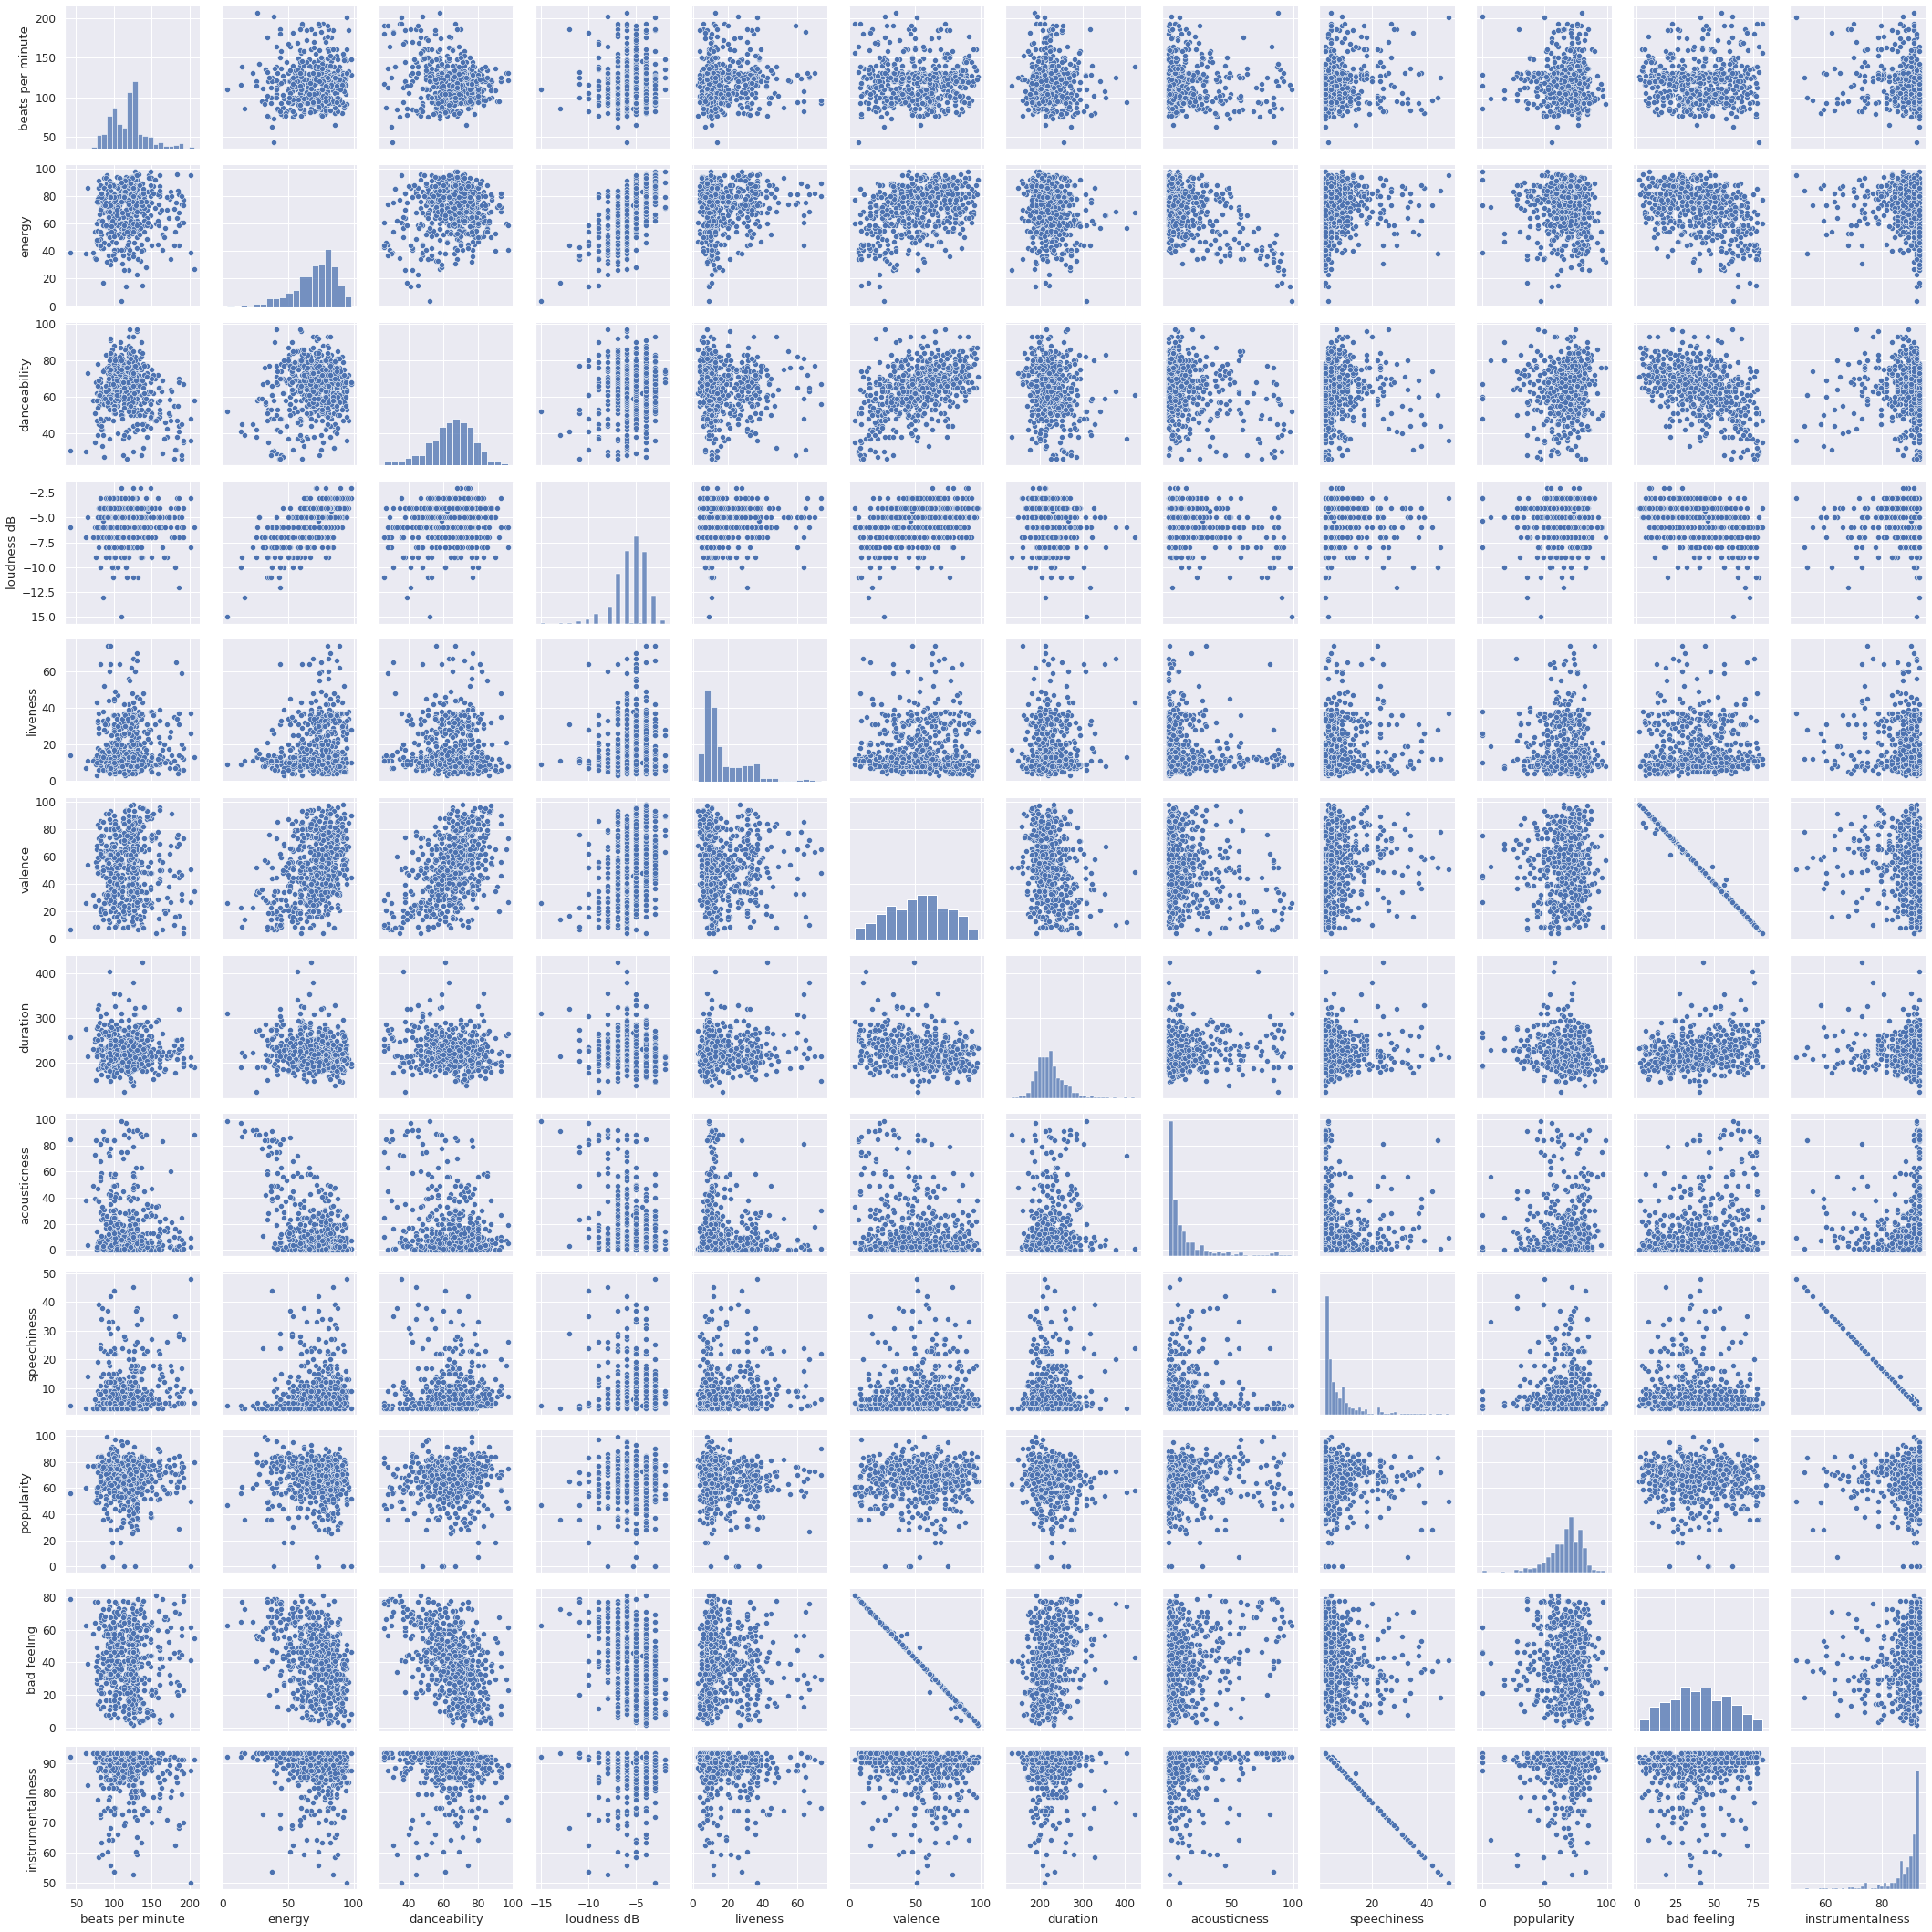

In [24]:
sns.pairplot(df.iloc[:, 4:])

/home/aigaf/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='valence', ylabel='danceability'>

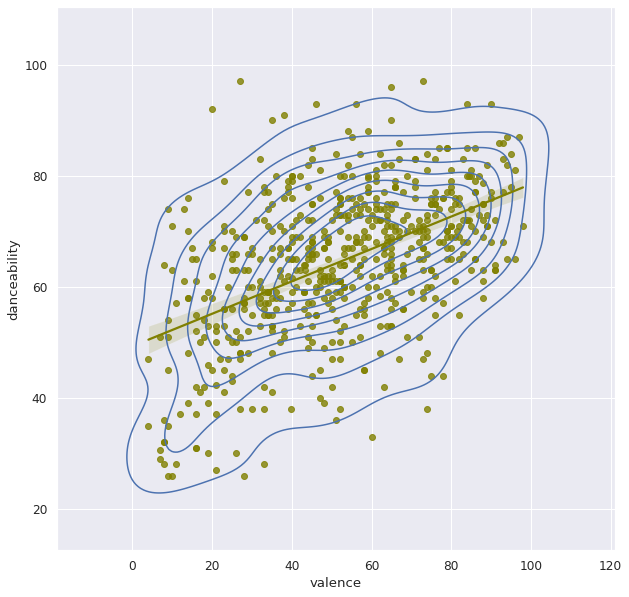

In [25]:
fig = plt.subplots(figsize = (10,10))

sns.regplot(x = 'valence', y = 'danceability', data = df, color = 'olive')

sns.kdeplot(df['valence'], df['danceability'])

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,602.0,2014.589701,2.608592,2010.000,2013.000,2015.000000,2017.00,2019.000
beats per minute,602.0,118.774640,24.223164,43.000,100.000,120.000000,129.00,206.000
energy,602.0,70.573643,16.055190,4.000,61.000,74.000000,82.00,98.000
danceability,602.0,64.570321,13.042925,26.000,57.000,66.000000,73.75,97.000
loudness dB,602.0,-5.491141,1.701199,-15.000,-6.000,-5.000000,-4.00,-2.000
liveness,602.0,17.799003,12.916331,3.000,9.000,12.000000,24.00,74.000
valence,602.0,52.281838,22.298694,4.000,35.000,52.000000,69.00,98.000
duration,602.0,224.678848,34.143340,134.000,202.000,220.500000,239.75,424.000
acousticness,602.0,14.381506,20.763547,0.000,2.000,6.000000,17.00,99.000
speechiness,602.0,8.385382,7.482417,3.000,4.000,5.666667,9.00,48.000


### We can find something intresting here

In [27]:
df_boxenplot = df.copy()
df_boxenplot = df_boxenplot.sample(frac=1, random_state = 42) # data is randomized

In [28]:
df_boxenplot.replace('dance pop', 'dance pop 1', inplace  = True)
df_boxenplot[:299].replace('dance pop 1', 'dance pop 2', inplace  = True)
df_boxenplot['genre'].value_counts()

/home/aigaf/.local/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


dance pop 1                  327
pop                           60
canadian pop                  34
boy band                      15
barbadian pop                 15
electropop                    13
british soul                  10
big room                      10
canadian contemporary r&b      9
neo mellow                     9
art pop                        8
complextro                     6
australian dance               6
hip pop                        6
atl hip hop                    5
edm                            5
australian pop                 5
permanent wave                 4
latin                          4
hip hop                        4
colombian pop                  3
tropical house                 3
folk-pop                       2
detroit hip hop                2
acoustic pop                   2
indie pop                      2
escape room                    2
candy pop                      2
downtempo                      2
canadian hip hop               2
electronic

In [29]:
order = df_boxenplot['genre'].value_counts()[df_boxenplot['genre'].value_counts().values > 10].index # get sorted genres with more than 10 songs

In [30]:
df_boxenplot['genre'].value_counts()[df_boxenplot['genre'].value_counts().values > 10].index

Index(['dance pop 1', 'pop', 'canadian pop', 'boy band', 'barbadian pop',
       'electropop'],
      dtype='object')

####  Every genre has different values for each feature and same genres have approximatly same values 

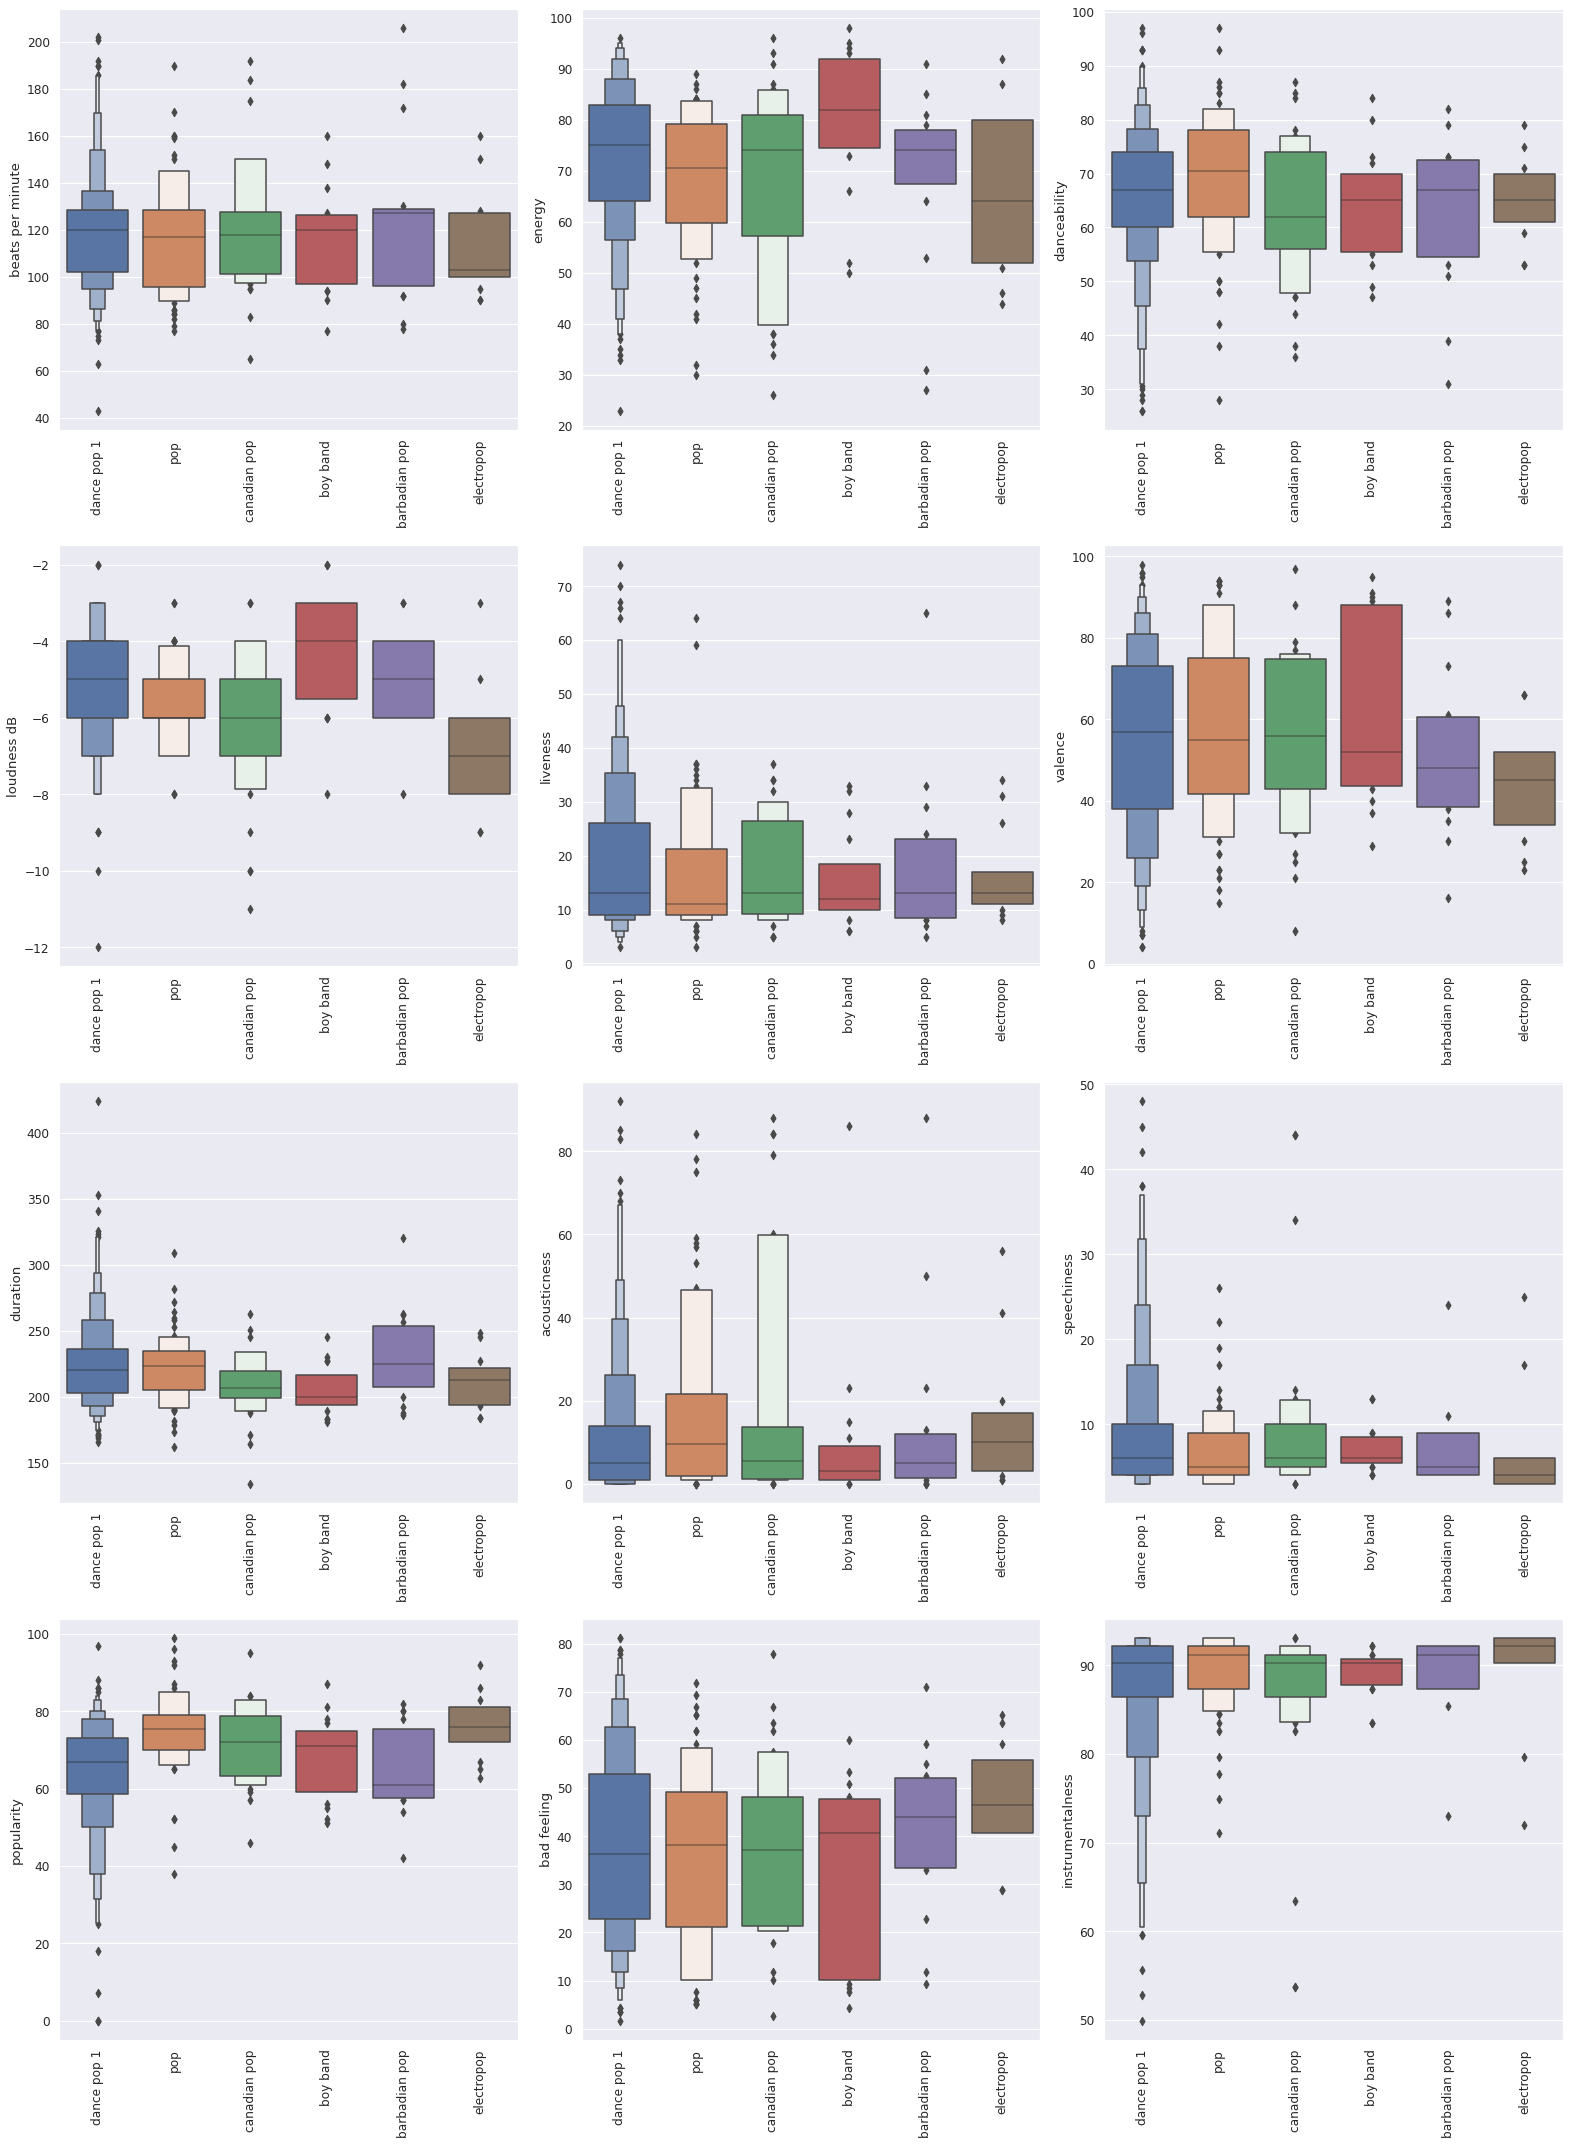

In [31]:
numerical_cols = df_boxenplot.drop('year', axis= 1).select_dtypes('number').columns.to_list()

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(22,30))
axs = np.ravel(axs)

for i, col in enumerate(numerical_cols):
    plt.sca(axs[i])
    #sns.catplot(y=col, x="top.genre", kind="boxen", data=df, order = order)
    sns.boxenplot(data=df_boxenplot, x='genre', y= col, order = order)
    plt.xlabel("")
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

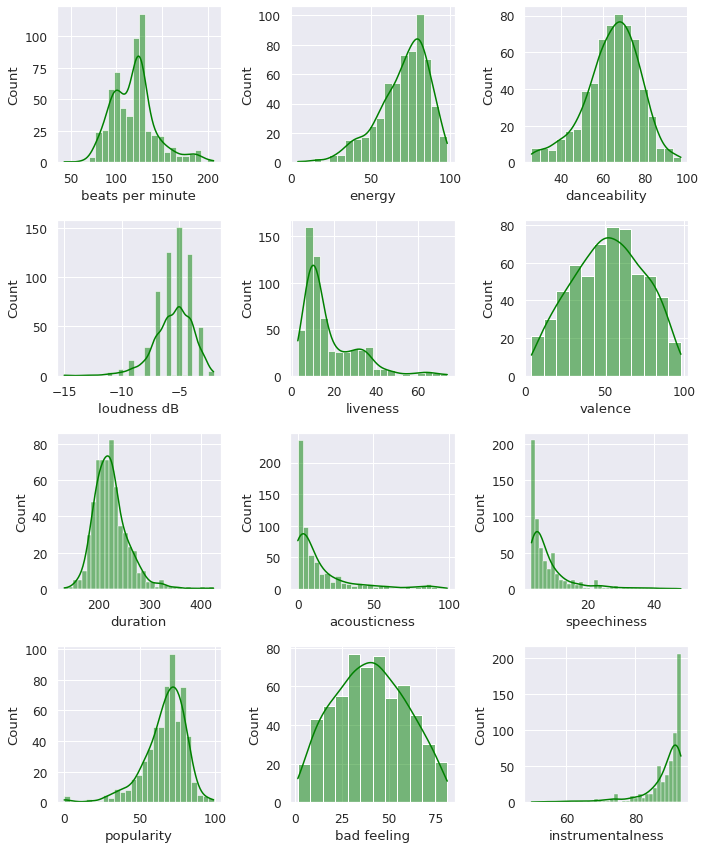

In [32]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,12))
axs = np.ravel(axs)

for i, col in enumerate(numerical_cols):
    plt.sca(axs[i])
    sns.histplot(data=df, x=col, kde=True, color='green')

plt.tight_layout()
plt.show()

* dnce, val, dur, emo, pop have an appoximately normal distribution.

* nrgy, dB, ins features are right Skewed

* live, acous, spch features are Left Skewed

#### Number of songs for each year

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,602.0,2014.589701,2.608592,2010.000,2013.000,2015.000000,2017.00,2019.000
beats per minute,602.0,118.774640,24.223164,43.000,100.000,120.000000,129.00,206.000
energy,602.0,70.573643,16.055190,4.000,61.000,74.000000,82.00,98.000
danceability,602.0,64.570321,13.042925,26.000,57.000,66.000000,73.75,97.000
loudness dB,602.0,-5.491141,1.701199,-15.000,-6.000,-5.000000,-4.00,-2.000
liveness,602.0,17.799003,12.916331,3.000,9.000,12.000000,24.00,74.000
valence,602.0,52.281838,22.298694,4.000,35.000,52.000000,69.00,98.000
duration,602.0,224.678848,34.143340,134.000,202.000,220.500000,239.75,424.000
acousticness,602.0,14.381506,20.763547,0.000,2.000,6.000000,17.00,99.000
speechiness,602.0,8.385382,7.482417,3.000,4.000,5.666667,9.00,48.000


In [34]:
df_norm = df.copy()

In [35]:
def min_max_scaling(series):
    return ((series - series.min())/(series.max()-series.min()))

def std_scaling(series):
    return ((series - series.mean())/(np.std(series)))

In [36]:
columns = df.columns[4:]
columns = df_norm.groupby("year")[columns].median().loc[2010].sort_values(ascending = False).index # sort columns by meadian value of 2010 year

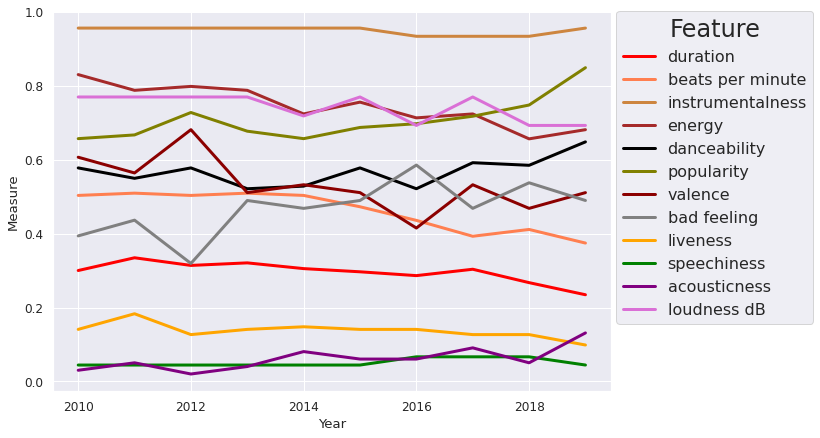

In [37]:
fig,ax = plt.subplots(figsize=(10, 7))

sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})

i = 0 
colors = ['red', 'coral', 'peru', 'brown', 'black', 'olive', 'darkred', 'gray', 'orange', 'green', 'purple', 'orchid']

for col in columns:
    df_norm[col] = min_max_scaling(df[col].values) 
    x = df_norm.groupby("year")[col].median()
    ax= sns.lineplot(x=x.index,y=x,label=col, color = colors[i], ci=None)
    i += 1

ax.set_ylabel('Measure')
ax.set_xlabel('Year')
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, title = "Feature", fontsize = 16)
sns.set(font_scale=1.6)

In general loudness dB, instrumentalness and speachcness features do not change much, songs are getting slightly instrumentalness. Songs are getting less energy, more danceable and popular, much less positive and more depressing, way shorter, less lively,  and  way more increasing. 

Lines of valence and bad feeling features are fully symmetric that means they have correlation, also speachness and instrumentalness (it is showed in correalatation heatmap).




In [38]:
top_5 = df['genre'].value_counts().index[:5]
df_tmp = df[df['genre'].isin(top_5)]
df_tmp = df_tmp.iloc[: , 2:14].drop('year', axis = 1)

df_top5 = df_tmp.groupby('genre').median()

In [39]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatterpolar(
      r=df_top5.iloc[4],
      theta=df_top5.columns,
      fill='toself',
      name='Pop'
))
fig.add_trace(go.Scatterpolar(
      r=df_top5.iloc[0],
      theta=df_top5.columns,
      fill='toself',
      name='Barbadian Pop'
))
fig.add_trace(go.Scatterpolar(
      r=df_top5.iloc[1],
      theta=df_top5.columns,
      fill='toself',
      name='Boy Band'
))
fig.add_trace(go.Scatterpolar(
      r=df_top5.iloc[2],
      theta=df_top5.columns,
      fill='toself',
      name='Canadian Pop'
))
fig.add_trace(go.Scatterpolar(
      r=df_top5.iloc[3],
      theta=df_top5.columns,
      fill='toself',
      name='Dance Pop'
))

fig.update_layout(
  
  showlegend=True
)

fig.show()

## PCA

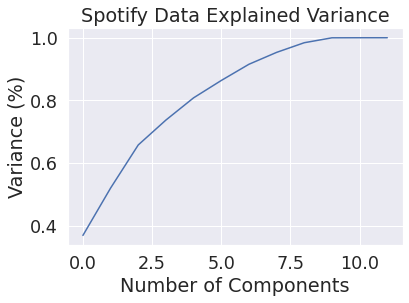

In [40]:
from sklearn.decomposition import PCA

pca = PCA().fit(df_norm.iloc[:, 4:])
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Spotify Data Explained Variance')
plt.show()

In [41]:
explained_variance = pca.explained_variance_ratio_

print(explained_variance[:9].sum())


0.9841302222239086


# Models

### Trying to predict popularity

In [42]:
from sklearn.preprocessing import LabelEncoder

artist_le= LabelEncoder()
artist_labels = artist_le.fit_transform(df_norm['artist'])
df_norm['artist'] = artist_labels

top_genre = LabelEncoder()
label_genres = top_genre.fit_transform(df_norm['genre'])
df_norm['genre'] = label_genres


In [43]:
X = df.drop(['popularity', 'title', 'artist', 'bad feeling', 'instrumentalness', 'year', 'genre'], axis = 1)
y = df['popularity']

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")


def cross_val_models(X, y):
    #model creation

    model_RF = RandomForestRegressor(n_estimators = 100,max_leaf_nodes = 2, random_state = 1)
    # model_XGB = XGBRegressor(n_estimators = 100, learning_rate = 0.5, n_jobs = 3, random_state = 42)
    lasso = Lasso(alpha =0.0005, random_state=1)
    KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    model_lgb = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=300,
                              max_bin = 10, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 2, min_sum_hessian_in_leaf = 4)

    ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
    GBoost = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split=4, 
                                   loss='huber', random_state =42)


    #averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

    
    kf = KFold(n_splits= 3, shuffle=True, random_state= 42)
    #Cross Validation
    scores1 = -1 * cross_val_score(model_RF, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error', )
    # scores3 = -1 * cross_val_score(model_XGB, X, y,
    #                               cv=kf,
    #                               scoring='neg_mean_absolute_error')
    scores4 = -1 * cross_val_score(lasso, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error')
    scores5 = -1 * cross_val_score(model_lgb, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error')
    scores6 = -1 * cross_val_score(ENet, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error')
    scores7 = -1 * cross_val_score(KRR, X, y,
                                  cv=kf,
                                  scoring='neg_mean_absolute_error')
    # scores8 = -1 * cross_val_score(averaged_models, X, y,
    #                               cv=kf,
    #                               scoring='neg_mean_absolute_error')

    

    print('model_RF',scores1.mean(), scores1.std())
    # print('model_XGB', scores3.mean(), scores3.std())
    print('lasso', scores4.mean(), scores4.std())
    print('model_lgb', scores5.mean(), scores5.std())
    print('ENet', scores6.mean(), scores6.std())
    print('KRR', scores7.mean(), scores7.std())
    #print(" Averaged base models score: {:.4f} ({:.4f})\n".format(scores8.mean(), scores8.std()))
    

In [73]:
X_std = X.apply(std_scaling)
cross_val_models(X,y)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [War

### Extra data is concatenated

In [74]:
df1= pd.read_csv('Spotify-2000.csv', encoding='ISO-8859-1')
df1 = df1.drop(['ï»¿Index', 'Title', 'Artist'], axis = 1)
df2 = df.drop(['title','instrumentalness', 'bad feeling', 'artist'], axis = 1)
df1.columns = df2.columns 
df_conc = pd.concat([df2, df1], ignore_index=True)
df_conc['duration'] = pd.to_numeric(df_conc['duration'], errors = 'coerce')

In [75]:
genres = df['genre'].value_counts().index
df_conc = df_conc[df_conc['genre'].isin(genres)]

In [76]:
df_conc = df_conc.dropna()
df_conc = df_conc.drop_duplicates()

In [77]:
top_genre = LabelEncoder()
label_genres = top_genre.fit_transform(df_conc['genre'])
df_conc['genre'] = label_genres

In [117]:
X = df_conc.drop(['popularity', 'genre', 'year'], axis = 1)
y = df_conc['popularity']
X_rob = X.copy()
X_rob.loc[:, :] = RobustScaler().fit_transform(X)

In [79]:
cross_val_models(X, y)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [War

### Grid search parameters 

In [80]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid ):
    kf = KFold(n_splits= 3, shuffle=True, random_state= 42)
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=kf, 
        n_jobs= -1, 
        scoring= 'neg_mean_absolute_error',
    )
 
    fitted_model = gs.fit(X_train_data, y_train_data)
    best_model = fitted_model.best_estimator_
    pred = fitted_model.predict(X_test_data)

    score = mean_absolute_error(y_test_data, pred)

    return [best_model, score]

In [90]:
# Defining the hyperparameters to optimize
grid_parameters = [
    { # LightGBM
        'n_estimators': [500, 600],
        'learning_rate': [0.005],
        'colsample_bytree': [0.5],
        'max_depth': [8, 9],
        'num_leaves': [20, 22],
        'reg_alpha': [0.4, 0.3],
        'reg_lambda': [1.1],
        'min_split_gain': [0.3],
        'subsample': [0.6],
        'subsample_freq': [10, 9]
    }, 
    { # Random Forest
        'max_depth':[15, 20], 
        'n_estimators':[250, 300],
        'max_features':[2],
        'min_samples_split' : [2],
        'min_samples_leaf' : [1]
        
    },
    {
        #Lasso####
        'alpha': [0.005, 0.05] 
    },

    {
        #KernelRidge
        'alpha': [30],
        'kernel' : ['polynomial'], 
        'degree' : [2],
        'coef0' : [11] 
    },
        #ElasticNet########
    {
        'alpha': [0.0005],
        'l1_ratio' : [0.7, 0.5] 
        
    },
    # GradientBoostingRegressor
    {
        'n_estimators' : [350, 370], 
        'learning_rate' : [0.005],
        'max_depth' : [5, 4, 3],
        'min_samples_leaf' : [2, 3],
        'min_samples_split' :[11, 12],
        'loss' : ['huber']
    }
]
def search_parameters(X, y, grid_parameters):        

    X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, 
                                    test_size=0.2, 
                                    random_state=42, shuffle = True)

    model_RF = RandomForestRegressor(random_state = 42)
    model_lasso = Lasso(random_state = 42)
    model_KRR = KernelRidge()
    model_lgb = LGBMRegressor(random_state = 42)
    model_ENet = ElasticNet(random_state = 42)
    model_GBoost = GradientBoostingRegressor(random_state = 42)

    models_to_train = [model_lgb, model_RF, model_lasso, model_KRR, model_ENet, model_GBoost]

    models_preds_scores = []

    for i, model in enumerate(models_to_train):
        print(i)
        params = grid_parameters[i]
        result = algorithm_pipeline(X_train, X_test, y_train, y_test, model, params)
        models_preds_scores.append(result)
        
    return models_preds_scores
        

  

In [119]:
scores = search_parameters(X_rob, y, grid_parameters) # takes some time
scores

0
1
2
3
4
5


[[LGBMRegressor(colsample_bytree=0.5, learning_rate=0.005, max_depth=9,
                min_split_gain=0.3, n_estimators=500, num_leaves=20,
                random_state=42, reg_alpha=0.3, reg_lambda=1.1, subsample=0.6,
                subsample_freq=10),
  10.245965425499348],
 [RandomForestRegressor(max_depth=20, max_features=2, n_estimators=250,
                        random_state=42),
  9.792523413106025],
 [Lasso(alpha=0.05, random_state=42), 10.621761666818854],
 [KernelRidge(alpha=30, coef0=11, degree=2, kernel='polynomial'),
  10.476980504162606],
 [ElasticNet(alpha=0.0005, random_state=42), 10.597783214316363],
 [GradientBoostingRegressor(learning_rate=0.005, loss='huber', min_samples_leaf=2,
                            min_samples_split=12, n_estimators=370,
                            random_state=42),
  10.309549861327753]]

### Stacking models 

In [120]:
best_parameters = []
for i in range(len(scores)):
    best_parameters.append(scores[i][0])

In [121]:
best_parameters

[LGBMRegressor(colsample_bytree=0.5, learning_rate=0.005, max_depth=9,
               min_split_gain=0.3, n_estimators=500, num_leaves=20,
               random_state=42, reg_alpha=0.3, reg_lambda=1.1, subsample=0.6,
               subsample_freq=10),
 RandomForestRegressor(max_depth=20, max_features=2, n_estimators=250,
                       random_state=42),
 Lasso(alpha=0.05, random_state=42),
 KernelRidge(alpha=30, coef0=11, degree=2, kernel='polynomial'),
 ElasticNet(alpha=0.0005, random_state=42),
 GradientBoostingRegressor(learning_rate=0.005, loss='huber', min_samples_leaf=2,
                           min_samples_split=12, n_estimators=370,
                           random_state=42)]

In [124]:
from mlxtend.regressor import StackingCVRegressor
stack = StackingCVRegressor(regressors=(best_parameters),
                            meta_regressor=XGBRegressor(), cv=5,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42, 
                            n_jobs = 6)


,beats per minute,energy,danceability,loudness dB,liveness,valence,duration,acousticness,speechiness
380,-0.600000,0.00,0.131579,-0.5,-0.307692,0.540541,-0.612245,-0.166667,1.50
2156,-0.866667,-0.40,0.026316,-3.5,0.692308,1.081081,-0.081633,0.708333,-0.50
355,0.066667,0.68,1.131579,0.5,-0.153846,0.810811,-0.857143,-0.166667,0.25
357,0.200000,0.52,-0.078947,0.5,-0.307692,-0.270270,-0.081633,-0.250000,0.75
362,2.733333,-1.28,-0.815789,-1.0,1.076923,-0.594595,-0.714286,-0.250000,1.00
...,...,...,...,...,...,...,...,...,...
2247,0.000000,-1.12,-0.657895,-2.0,-0.461538,-0.756757,1.653061,0.416667,-0.25
583,-0.900000,-0.24,0.657895,-1.0,-0.307692,0.162162,-0.612245,0.166667,3.50
2146,1.800000,0.76,-1.184211,-1.0,0.538462,0.486486,0.918367,1.458333,-0.50
1040,0.666667,-0.48,-0.973684,-0.5,-0.307692,-0.783784,1.040816,-0.125000,-0.50


In [134]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [145]:
averaged_models = AveragingModels(models = (best_parameters))
averaged_models.fit(X_train, y_train)
y_pred = averaged_models.predict(X_test)

In [147]:
mean_absolute_error(y_pred, y_test)

10.266662547982214

## Spotify API

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import requests
import json

CLIENT_ID = "8e0273854b3b41d5b0e5d57709dacee8"
CLIENT_SECRET = "a222499edd0b4a9d97d65c6a0698b244"

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = '8e0273854b3b41d5b0e5d57709dacee8'
secret = 'a222499edd0b4a9d97d65c6a0698b244'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
artist_name = []
track_name = []
popularity = []
track_id = []
genres = []
for i in range(0,10,50):
    track_results = sp.search(q='year:2017', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])

        artist_uri = t['album']['artists'][0]['uri']
        artist_info = sp.artist(artist_uri)
        artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])

        try:
            genres.append(artist["genres"][0])
        except:
            genres.append(np.NaN)
        

        
        

In [ ]:
artist_uri = t['album']['artists'][0]['uri']
artist_info = sp.artist(artist_uri)
artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])
artist["genres"][0]

In [ ]:
dict = {'title': track_name, 'artist': artist_name, 'top.genre': genres, 'year':2018}
pd.DataFrame(dict)